In [1]:
# Import libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import itertools
import argparse
import sys
import time
from sklearn import preprocessing
import pandas as pd
import os
import math #YKH
import random #YKH
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'


In [39]:
## Preprocessing of data


#load data
data = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)


X_ = pd.DataFrame(data.iloc[:,2:6], columns=["Global_active_power","Global_reactive_power","Voltage","Global_intensity"])
Y_ = pd.DataFrame(data.iloc[:,7], columns=["Sub_metering_2"])

X_ = X_.replace({'?':0})
Y_ = Y_.replace({'?':0})




X_features = X_.columns
Y_features = Y_.columns

number_of_samples = 20000 #YKH: as dimension is high we select part of that to see how algorithms work 

XY = pd.concat([X_[X_features], Y_[Y_features]], axis=1).iloc[0:number_of_samples,:]

# Split XY into training set and test set of equal size
train, test = train_test_split(XY, test_size = 0.25)
# Sort the train and test sets after index (which became unsorted through sampling)
train = train.sort_index(axis=0)
test = test.sort_index(axis=0)

# Extract X,Y components from test and train sets
X_train = train[X_features].astype(float); X_test = test[X_features].astype(float)
Y_train = train[Y_features].astype(float); Y_test = test[Y_features].astype(float)

print("Size of train set (X): ",X_train.shape)
print("Size of train set (Y): ",Y_train.shape)
print("Size of test set (X): ",X_test.shape)
print("Size of test set (Y): ",Y_test.shape)

Size of train set (X):  (15000, 4)
Size of train set (Y):  (15000, 1)
Size of test set (X):  (5000, 4)
Size of test set (Y):  (5000, 1)


In [40]:
# YKH

# feature standarization: mean=0, variance=1
from sklearn import preprocessing
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)



# initialize_parameters_deep

epsilon = 1e-9

# initializing W and b(bias)

def initialize_parameters_deep(layer_dims):
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * epsilon
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        
    return parameters

In [41]:
#define functions

# linear_forward
def linear_forward(A, W, b):

    Z = np.dot(W,A)+b
    cache = (A, W, b)
    
    return Z, cache

# sigmoid function
def sigmoid(z):

    s = 1/(1+np.exp((-1)*z))
    activation_cache = {"Z": z} 
    
    return s,activation_cache

def dsigmoid(z):

    s = z*(1-z)   
    
    return s


# linear function
def linear(z):
    s=z
    activation_cache = {"Z":z}
    
    return s,activation_cache

def dlinear(z):
    return 1


def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    

    elif activation == "linear":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = linear(Z)

    cache = (linear_cache, activation_cache)

    return A, cache


# L_model_forward
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    for l in range(1, L):
        A_prev = A 
        
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "sigmoid")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "linear")
    caches.append(cache)
              
    return AL, caches


# cost
def compute_cost(A2, Y):

    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    diff = (A2-Y)**2
    cost = np.sum(diff)/m 
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                             
    return cost


def sigmoid_backward(dA, activation_cache):
    dZ = dA*dsigmoid(activation_cache['Z'])
    return dZ

def line_backward(dA, activation_cache):
    dZ = dA*dlinear(activation_cache['Z'])
    return dZ

#linear_backward
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ,A_prev.T)/m
    db = (np.sum(dZ,axis=1,keepdims=True)/m)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db


#linear_activation_backward
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache

    dZ = sigmoid_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ,linear_cache)

    return dA_prev, dW, db


#L_model_backward
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = 2*np.sum(AL-Y)/m
    
    current_cache = caches[L-1]

    linear_cache, activation_cache = current_cache
    A_prev, W, b = linear_cache
    
    grads["dA" + str(L)] = dAL
    grads["dW" + str(L)] = 2 * np.dot((AL-Y),A_prev.T)/m
    grads["db" + str(L)] = dAL
    
    for l in reversed(range(L-1)):

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "sigmoid")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

#update_parameters
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(1, L+1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - np.multiply(learning_rate , grads["dW"+str(l)])
        parameters["b" + str(l)] = parameters["b" + str(l)] - np.multiply(learning_rate , grads["db"+str(l)])

    return parameters

#update_parameters for SVRG algorithm
def update_parameters_SVRG(parameters, grads, grads_tilda, total_grads, learning_rate,N):

    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(1, L+1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - np.multiply(learning_rate , grads["dW"+str(l)]-grads_tilda["dW"+str(l)]+total_grads["dW"+str(l)]/N)
        parameters["b" + str(l)] = parameters["b" + str(l)] - np.multiply(learning_rate , grads["db"+str(l)]-grads_tilda["db"+str(l)]+total_grads["db"+str(l)]/N)

    return parameters

#update_parameters for SAG alorithm
def update_parameters_SAG(parameters,grads, SAG_grads, random_index, learning_rate):

    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(1, L+1):
        if (l == random_index):
            parameters["W" + str(l)] = parameters["W" + str(l)] - np.multiply(learning_rate , grads["dW"+str(l)])
            parameters["b" + str(l)] = parameters["b" + str(l)] - np.multiply(learning_rate , grads["db"+str(l)])
        else:
            parameters["W" + str(l)] = parameters["W" + str(l)] - np.multiply(learning_rate , SAG_grads[l]["dW"+str(l)])
            parameters["b" + str(l)] = parameters["b" + str(l)] - np.multiply(learning_rate , SAG_grads[l]["db"+str(l)])

    return parameters

In [58]:
# set parameter
random_index = int(random.randint(1,X_train.shape[1]))
layers_dims = [4, 4, 1] #  3-layer model

In [59]:
#L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, epoch_length = 50, print_cost=True, solver="GD"):

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    parameters_tilda = initialize_parameters_deep(layers_dims)
    SAG_grads = [dict() for x in range(X.shape[1])]
    
    # Loop (gradient descent)
    if (solver == "GD"):
        for i in range(0, num_iterations):

            # Forward propagation:  LINEAR -> SIGMOID.
            AL, caches = L_model_forward(X, parameters)

            # Compute cost.
            cost = compute_cost(AL, Y)

            # Backward propagation.
            grads = L_model_backward(AL, Y, caches)

            # Update parameters.
            parameters = update_parameters(parameters, grads, learning_rate)


    elif (solver == "SGD"):
        for i in range(0, num_iterations):
            random_index = int(random.randint(1,X.shape[1]-1))
            random_sample_X = (X[:,random_index]).reshape(X.shape[0],1)
            random_sample_Y = (Y[:,random_index]).reshape(1,1)
            
            # Forward propagation:  LINEAR -> SIGMOID.
            AL, caches = L_model_forward(random_sample_X, parameters)

            # Compute cost.
            cost = compute_cost(AL, random_sample_Y)

            # Backward propagation.
            grads = L_model_backward(AL, random_sample_Y, caches)

            # Update parameters.
            parameters = update_parameters(parameters, grads, learning_rate)


        
    elif (solver == "SVRG"):
        for i in range(0, num_iterations):
            # Forward propagation: LINEAR -> SIGMOID.
            AL, caches = L_model_forward(X, parameters_tilda)

            # Compute cost.
            cost = compute_cost(AL, Y)

            # Backward propagation. Tilda gradian f
            total_grads = L_model_backward(AL, Y, caches)
            
            for j in range(0,epoch_length):
                random_index = int(random.randint(1,X.shape[1]-1))
                random_sample_X = (X[:,random_index]).reshape(X.shape[0],1)
                random_sample_Y = (Y[:,random_index]).reshape(1,1)

                # Forward propagation:  LINEAR -> SIGMOID.
                AL, caches = L_model_forward(random_sample_X, parameters)

                # Compute cost.
                cost = compute_cost(AL, random_sample_Y)

                # Backward propagation.
                grads = L_model_backward(AL, random_sample_Y, caches)
                
                # Forward propagation: LINEAR -> SIGMOID.
                AL_tilda, caches_tilda = L_model_forward(random_sample_X, parameters_tilda)

                # Compute cost.
                cost_tilda = compute_cost(AL_tilda, random_sample_Y)

                # Backward propagation.
                grads_tilda = L_model_backward(AL_tilda, random_sample_Y, caches_tilda)

                # Update parameters.
                parameters = update_parameters_SVRG(parameters, grads, grads_tilda, total_grads, learning_rate,X.shape[1])
            
            parameters_tilda = parameters
            
    elif (solver == "SAG"):
        #Computing all gradients for all samples
        for i in range(X.shape[1]):
            
            sample_X = (X[:,i]).reshape(X.shape[0],1)
            sample_Y = (Y[:,i]).reshape(1,1)

            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = L_model_forward(sample_X, parameters)

            # Compute cost.
            cost = compute_cost(AL, sample_Y)

            # Backward propagation.
            grads = L_model_backward(AL, sample_Y, caches)
            SAG_grads[i] = grads
        
        
        
        for j in range(0,epoch_length):
            random_index = int(random.randint(1,X.shape[1]-1))
            random_sample_X = (X[:,random_index]).reshape(X.shape[0],1)
            random_sample_Y = (Y[:,random_index]).reshape(1,1)

            # Forward propagation: LINEAR -> SIGMOID.
            AL, caches = L_model_forward(random_sample_X, parameters)

            # Compute cost.
            cost = compute_cost(AL, random_sample_Y)
            grads = L_model_backward(AL, sample_Y, caches)
            
            # Update parameters.
            parameters = update_parameters_SAG(parameters, grads, SAG_grads, random_index, learning_rate)

    
    return parameters

In [60]:
def predict(parameters, X):

    A2, cache = L_model_forward(X,parameters)
    predictions = A2 
    
    return predictions



# compute Normalized Mean Absolute Error
def nmae(y,yhat):
    y = np.array(y).reshape(y.shape[0],1)
    yhat = np.array(yhat).reshape(yhat.shape[0],1)
    result = np.sum(np.abs(y-yhat))/(y.shape[0]*np.mean(y))
    return result



In [61]:
# GD method

start = time.time()
parameters = L_layer_model(X_train.T, np.array(Y_train).T, layers_dims, solver = "GD", learning_rate = 0.001, num_iterations = 500, print_cost = True)
end = time.time()

train_time = end - start 

test_predicted_values = predict(parameters, X_test.T)
train_predicted_values = predict(parameters, X_train.T)

test_nmae = nmae(Y_test,test_predicted_values.T)
train_nmae = nmae(Y_train,train_predicted_values.T)

print("The train NMAE for GD is %.2f" %train_nmae)
print("The test NMAE for GD is %.2f" %test_nmae)
print("Training time for GD is %.2f" %train_time)


# SGD

start = time.time()
parameters = L_layer_model(X_train.T, np.array(Y_train).T, layers_dims, solver = "SGD", learning_rate = 0.001, num_iterations = 500, print_cost = True)
end = time.time()

train_time = end - start 

test_predicted_values = predict(parameters, X_test.T)
train_predicted_values = predict(parameters, X_train.T)

test_nmae = nmae(Y_test,test_predicted_values.T)
train_nmae = nmae(Y_train,train_predicted_values.T)

print("The train NMAE for SGD is %.2f" %train_nmae)
print("The test NMAE for SGD is %.2f" %test_nmae)
print("Training time for SGD is %.2f" %train_time)



# SVRG
start = time.time()
parameters = L_layer_model(X_train.T, np.array(Y_train).T, layers_dims, solver = "SVRG", learning_rate = 0.001, num_iterations = 500, print_cost = True)
end = time.time()

train_time = end - start 

test_predicted_values = predict(parameters, X_test.T)
train_predicted_values = predict(parameters, X_train.T)

test_nmae = nmae(Y_test,test_predicted_values.T)
train_nmae = nmae(Y_train,train_predicted_values.T)

print("The train NMAE for SVRG is %.2f" %train_nmae)
print("The test NMAE for SVRG is %.2f" %test_nmae)
print("Training time for SVRG is %.2f" %train_time)


# SAG
start = time.time()
parameters = L_layer_model(X_train.T, np.array(Y_train).T, layers_dims, solver = "SAG", learning_rate = 0.001, num_iterations = 500, print_cost = True)
end = time.time()

train_time = end - start 

test_predicted_values = predict(parameters, X_test.T)
train_predicted_values = predict(parameters, X_train.T)

test_nmae = nmae(Y_test,test_predicted_values.T)
train_nmae = nmae(Y_train,train_predicted_values.T)

print("The train NMAE for SAG is %.2f" %train_nmae)
print("The test NMAE for SAG is %.2f" %test_nmae)
print("Training time for SAG is %.2f" %train_time)

The train NMAE for GD is 1.49
The test NMAE for GD is 1.48
Training time for GD is 0.45
The train NMAE for SGD is 1.57
The test NMAE for SGD is 1.55
Training time for SGD is 0.03
The train NMAE for SVRG is 1.00
The test NMAE for SVRG is 1.00
Training time for SVRG is 4.22
The train NMAE for SAG is 1.07
The test NMAE for SAG is 1.07
Training time for SAG is 0.71


In [62]:
#L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.01, num_iterations = 3000, epoch_length = 50, print_cost=True, solver="GD"):

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    parameters_tilda = initialize_parameters_deep(layers_dims)
    SAG_grads = [dict() for x in range(X.shape[1])]

    # Loop (gradient descent)
    if (solver == "GD"):
        ti= np.zeros((num_iterations,1))
        cost_= np.zeros((num_iterations,1))
        for i in range(0, num_iterations):
            start = time.time()
            # Forward propagation:  LINEAR -> SIGMOID.
            AL, caches = L_model_forward(X, parameters)

            # Compute cost.
            cost = compute_cost(AL, Y)
            cost_[i,0] = cost 
            # Backward propagation.
            grads = L_model_backward(AL, Y, caches)

            # Update parameters.
            parameters = update_parameters(parameters, grads, learning_rate)
            end = time.time()
            ti[i,0] = end-start
            
    elif (solver == "SGD"):
        ti= np.zeros((num_iterations,1))
        cost_= np.zeros((num_iterations,1))
        for i in range(0, num_iterations):
            start = time.time()
            random_index = int(random.randint(1,X.shape[1]-1))
            random_sample_X = (X[:,random_index]).reshape(X.shape[0],1)
            random_sample_Y = (Y[:,random_index]).reshape(1,1)
            
            # Forward propagation:  LINEAR -> SIGMOID.
            AL, caches = L_model_forward(random_sample_X, parameters)

            # Compute cost.
            cost = compute_cost(AL, random_sample_Y)
            cost_[i,0] = cost 
            # Backward propagation.
            grads = L_model_backward(AL, random_sample_Y, caches)

            # Update parameters.
            parameters = update_parameters(parameters, grads, learning_rate)
            end = time.time()
            ti[i,0] = end-start

        
    elif (solver == "SVRG"):
        ti= np.zeros((num_iterations,1))
        cost_= np.zeros((num_iterations,1))
        for i in range(0, num_iterations):
            # Forward propagation: LINEAR -> SIGMOID.
            start = time.time()
            AL, caches = L_model_forward(X, parameters_tilda)

            # Compute cost.
            cost = compute_cost(AL, Y)
            cost_[i,0] = cost 
            # Backward propagation. Tilda gradian f
            total_grads = L_model_backward(AL, Y, caches)
            
            for j in range(0,epoch_length):
                random_index = int(random.randint(1,X.shape[1]-1))
                random_sample_X = (X[:,random_index]).reshape(X.shape[0],1)
                random_sample_Y = (Y[:,random_index]).reshape(1,1)

                # Forward propagation:  LINEAR -> SIGMOID.
                AL, caches = L_model_forward(random_sample_X, parameters)

                # Compute cost.
                cost = compute_cost(AL, random_sample_Y)

                # Backward propagation.
                grads = L_model_backward(AL, random_sample_Y, caches)
                
                # Forward propagation: LINEAR -> SIGMOID.
                AL_tilda, caches_tilda = L_model_forward(random_sample_X, parameters_tilda)

                # Compute cost.
                cost_tilda = compute_cost(AL_tilda, random_sample_Y)

                # Backward propagation.
                grads_tilda = L_model_backward(AL_tilda, random_sample_Y, caches_tilda)

                # Update parameters.
                parameters = update_parameters_SVRG(parameters, grads, grads_tilda, total_grads, learning_rate,X.shape[1])
            
            parameters_tilda = parameters
            end = time.time()
            ti[i,0] = end-start
            
    elif (solver == "SAG"):
        
        #Computing all gradients for all samples
        for i in range(X.shape[1]):
            
            sample_X = (X[:,i]).reshape(X.shape[0],1)
            sample_Y = (Y[:,i]).reshape(1,1)

            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = L_model_forward(sample_X, parameters)

            # Compute cost.
            cost = compute_cost(AL, sample_Y)

            # Backward propagation.
            grads = L_model_backward(AL, sample_Y, caches)
            SAG_grads[i] = grads
        
        
        ti= np.zeros((num_iterations,1))
        cost_= np.zeros((epoch_length,1))
        for j in range(0,epoch_length):
            random_index = int(random.randint(1,X.shape[1]-1))
            random_sample_X = (X[:,random_index]).reshape(X.shape[0],1)
            random_sample_Y = (Y[:,random_index]).reshape(1,1)

            # Forward propagation: LINEAR -> SIGMOID.
            AL, caches = L_model_forward(random_sample_X, parameters)

            # Compute cost.
            cost = compute_cost(AL, random_sample_Y)
            cost_[i,0] = cost 
            grads = L_model_backward(AL, sample_Y, caches)
            
            # Update parameters.
            parameters = update_parameters_SAG(parameters, grads, SAG_grads, random_index, learning_rate)
            end = time.time()
            ti[i,0] = end-start
    
    return parameters, cost_ , ti

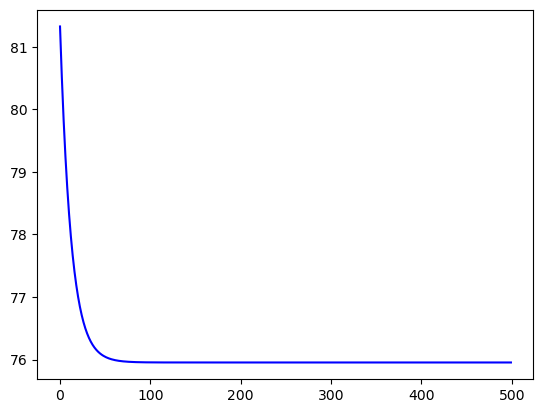

In [79]:
parameters , cost_1 , ti= L_layer_model(X_train.T, np.array(Y_train).T, layers_dims, solver = "GD", learning_rate = 0.01, num_iterations = 500)
l0 = plt.plot(cost_1[:,0],color="blue")


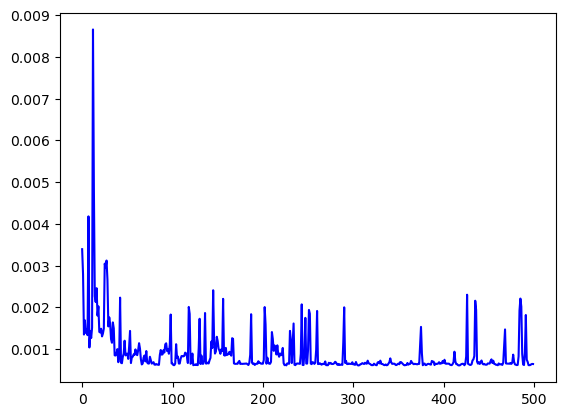

In [80]:
l0 = plt.plot(ti[:,0],color="blue")

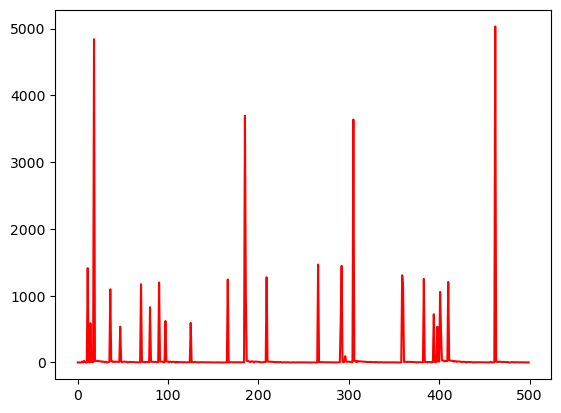

In [81]:
parameters , cost_1 , ti= L_layer_model(X_train.T, np.array(Y_train).T, layers_dims, solver = "SGD", learning_rate = 0.01, num_iterations = 500)
l0 = plt.plot(cost_1[:,0],color="red")

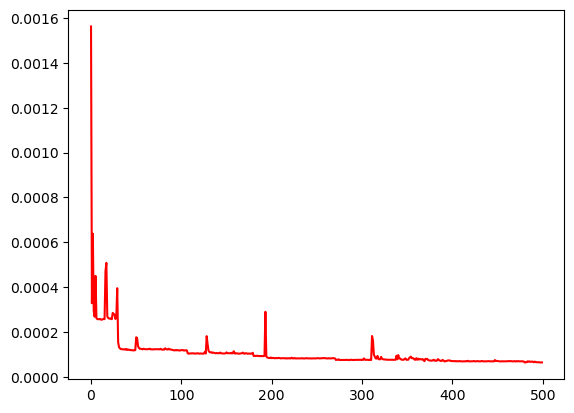

In [82]:
l0 = plt.plot(ti[:,0],color="red")

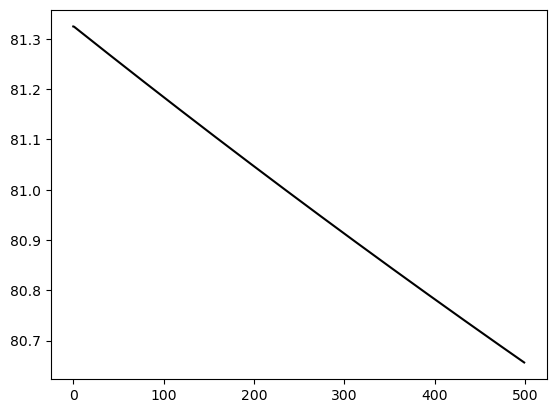

In [83]:
parameters , cost_1 , ti= L_layer_model(X_train.T, np.array(Y_train).T, layers_dims, solver = "SVRG", learning_rate = 0.01, num_iterations = 500)
l0 = plt.plot(cost_1[:,0],color="black")

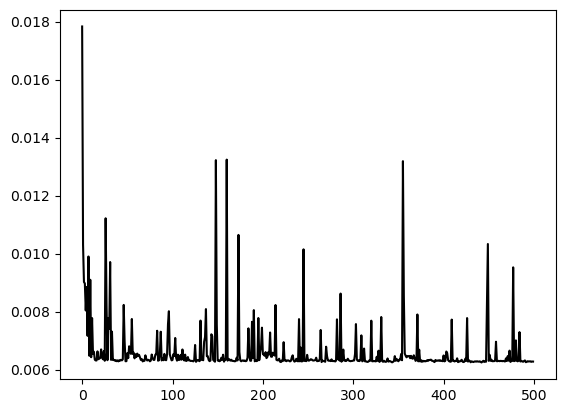

In [84]:
l0 = plt.plot(ti[:,0],color="black")